In [10]:
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import shutil as sh
import math
import time
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [107]:
class vdw_vol():
    def __init__(self):
        self.path='/Users/jigenji/Working/interaction/BTBT/vdw/'
        self.A1_list=[round(A1) for A1 in np.linspace(0,45,46)]
        self.A2_list=[0]#[round(A2) for A2 in np.linspace(0,45,46)]
        self.A3_list=[round(A3) for A3 in np.linspace(0,45,46)]#[38.3561]#
#         self.A3_list=[round(A3) for A3 in np.linspace(0,45,46)]
        self.theta_list=np.linspace(0,90,91)
        #self.opt_list=[[3.8,2.9,20],[4.1,2.3,30],[4.3,1.8,40],[4.4,1.5,45],[4.5,1.2,50],[4.6,0.9,55],[4.8,0.5,60],[5.0,-0.2,70],[5.1,-1.0,80],[5.0,0.0,90]]

    def Rod(self,n,theta_in):
        nx,ny,nz=n
        theta_t=np.radians(theta_in)
        Rod=np.array([[np.cos(theta_t)+(nx**2)*(1-np.cos(theta_t)),nx*ny*(1-np.cos(theta_t))-nz*np.sin(theta_t),nx*nz*(1-np.cos(theta_t))+ny*np.sin(theta_t)],
                    [nx*ny*(1-np.cos(theta_t))+nz*np.sin(theta_t),np.cos(theta_t)+(ny**2)*(1-np.cos(theta_t)),ny*nz*(1-np.cos(theta_t))-nx*np.sin(theta_t)],
                    [nx*nz*(1-np.cos(theta_t))-ny*np.sin(theta_t),ny*nz*(1-np.cos(theta_t))+nx*np.sin(theta_t),np.cos(theta_t)+(nz**2)*(1-np.cos(theta_t))]])
        return Rod

#分子1分子2を作成(回転させただけ・平行移動なし)
    def convertor(self,atom_list,A1,A2,A3):
        self.n=np.array([np.sin(np.radians(A1))*np.cos(np.radians(A2)),
                         np.sin(np.radians(A1))*np.sin(np.radians(A2)),
                         np.cos(np.radians(A1))])######回転軸
        atom_list_rt=[]
        for x,y,z,R in atom_list:
            x1,y1,z1=np.matmul(self.Rod(np.array([0,1,0]),A1),np.array([x,y,z]).T)
            x2,y2,z2=np.matmul(self.Rod(np.array([0,0,1]),A2),np.array([x1,y1,z1]).T)
            x3,y3,z3=np.matmul(self.Rod(self.n,A3),np.array([x2,y2,z2]).T)
            atom_list_rt.append([x3,y3,z3,R])
        return np.array(atom_list_rt)

####R返す関数
    def vdw_R(self,A1,A2,A3,theta,mode,glide_mode):
        df_anth=pd.read_csv(self.path+'monomer.csv')###x,y,z,rad
        anth=df_anth[['X','Y','Z','R']].values
        anth_1=self.convertor(anth,A1,A2,A3)
        glide=180.0 if glide_mode=='a' else 0.0
        if mode=='t':
            anth_2=self.convertor(anth,A1,-A2,-A3+glide)#回転させただけ
        elif mode=='a' or mode=='b':
            anth_2=self.convertor(anth,A1,A2,A3)
        R_clps=0
        for x1,y1,z1,rad1 in anth_1:
            for x2,y2,z2,rad2 in anth_2:
                eR=np.array([np.cos(np.radians(theta)),np.sin(np.radians(theta)),0.0])
                R_1b=np.dot(eR,np.array([x1,y1,z1]))
                R_2b=np.dot(eR,np.array([x2,y2,z2]))
                R_12=np.array([x2-x1,y2-y1,z2-z1])
                R_12b=np.dot(eR,R_12)
                R_12a=np.linalg.norm(R_12-R_12b*eR)
                if (rad1+rad2)**2-R_12a**2<0:
                    continue
                else:
                    R_clps=max(R_clps,R_1b-R_2b+np.sqrt((rad1+rad2)**2-R_12a**2))
        return R_clps

    def make_csv(self,name_csv,glide_mode):
        start=time.time()
        df_vdw=pd.DataFrame(columns=['A1','A2','A3','theta','R','S','a','b'])
        for A1 in tqdm(self.A1_list):
            for A2 in self.A2_list:
#                 if A1==0 and A2 >-90 :
#                     continue
                for A3 in self.A3_list:
                    print('A1={} A2={} A3={}'.format(A1,A2,A3))
                    a_clps=self.vdw_R(A1,A2,A3,0.0,'a','b')
                    b_clps=self.vdw_R(A1,A2,A3,90.0,'b','b')
                    for theta in self.theta_list:
                        R_clps=self.vdw_R(A1,A2,A3,theta,'t',glide_mode)
                        a=2*R_clps*np.cos(np.radians(theta))
                        b=2*R_clps*np.sin(np.radians(theta))
                        if (a_clps > a) or (b_clps > b):
                            continue
                        else:
                            S=a*b
                            data=pd.Series([A1,A2,A3,theta,R_clps,S,a,b],index=df_vdw.columns)
                            df_vdw=df_vdw.append(data,ignore_index=True)
        self.df_vdw=df_vdw
        df_vdw.to_csv(self.path+name_csv)
        end=time.time()
        print('time:{}s'.format(end-start))
        
    def cmap(self,name_csv):##self.listによってカスタマイズする
        df_vdw=pd.read_csv(self.path+name_csv)
        plt.rcParams['font.size']=15
        plt.rcParams['figure.figsize']=8,60
        ind_fig=0
        plt.axes().set_aspect('equal','datalim')
        for ind,A3 in enumerate(self.A3_list):
            ###複製の準備
            ind_fig+=1
            plt.subplot(len(self.A3_list),1,ind_fig)
            plt.xscale=10
            plt.yscale=10
            plt.xlim([0,8])
            plt.ylim([0,8])
            plt.xlabel('Ra Å')
            plt.ylabel('Rb Å')

            df_A3=df_vdw[df_vdw['A3']==A3]
            R_list=df_A3['R'].values
            theta_list=df_A3['theta'].values
            x_list=[R_list[i]*np.cos(np.radians(theta_list[i])) for i in range(len(theta_list))]
            y_list=[R_list[i]*np.sin(np.radians(theta_list[i])) for i in range(len(theta_list))]
            S_list=df_A3['S'].values
            R1_min=np.round(x_list[np.argmin(S_list)]*np.cos(np.radians(A3))+y_list[np.argmin(S_list)]*np.sin((np.radians(A3))),1)
            R2_min=np.round(y_list[np.argmin(S_list)]*np.cos(np.radians(A3))-x_list[np.argmin(S_list)]*np.sin((np.radians(A3))),1)
            plt.title('heri={} S_min:{} R1_min={} R2_min={}'.format(A3*2,min(S_list),R1_min,R2_min))
            plt.scatter(x_list,y_list,c=S_list)#,label='{}deg'.format(int(A2)))#,color=cm.jet(ind/len(self.A2_list)))#
            plt.scatter(x_list[np.argmin(S_list)],y_list[np.argmin(S_list)],marker='D',color='blue',label='vdwmin')
            plt.legend(bbox_to_anchor=(1,1),loc='upper left')
        plt.show()
        #print('min:V={} Ra={} Rb={} R3={}'.format(min(V_list),Ra_list[np.argmin(V_list)],Rb_list[np.argmin(V_list)],R3_list[np.argmin(V_list)]))

    def plot_3D(self,name_csv,heri):
        #import data
        df=pd.read_csv(self.path+name_csv)
        df_A3=df[df.A3==round(heri/2)]
        Ra_list=df_A3['a'].values/2
        Rb_list=df_A3['b'].values/2
        S_list=df_A3['S'].values
        # Figureを追加
        fig = plt.figure(figsize = (8, 8))

        # 3DAxesを追加
        ax = fig.add_subplot(111, projection='3d')

        # Axesのタイトルを設定
        ax.set_title("vdw-contact heri="+str(heri), size = 20)

        # 軸ラベルを設定
        ax.set_xlabel("Ra Å", size = 14)
        ax.set_ylabel("Rb Å", size = 14)
        ax.set_zlabel("S Å", size = 14)

        # 軸目盛を設定
#         ax.set_xticks([-1.0, -0.5, 0.0, 0.5, 1.0])
#         ax.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])

        # 曲線を描画
        ax.plot(Ra_list, Rb_list, S_list, color = "red")
        ax.scatter(Ra_list,Rb_list,c=S_list)

        plt.show()
        
    #make_gjf用。探索範囲絞るためのcsv作成
    def make_csv_vdwmin(self,in_csv,out_csv,edge_mode):#out_csv=vdw_a-edge_for_inp.csvとか。edge_mode:a端かb端か
        df_vdw=pd.read_csv(self.path+in_csv)
        df_contact=pd.DataFrame(columns=df_vdw.columns)
        idx_edge=0 if edge_mode=='a' else -1 #a端なら最初、b端なら最後の一行
        for A1 in self.A1_list:
            for A2 in self.A2_list:
                for A3 in self.A3_list:
                    df_A=df_vdw[(df_vdw['A1']==A1)&(df_vdw['A2']==A2)&(df_vdw['A3']==A3)].reset_index(drop=True)
                    data=pd.Series(df_A.iloc[idx_edge,:],index=df_contact.columns)
                    df_contact=df_contact.append(data,ignore_index=True)
        df_contact.to_csv(self.path+out_csv,index=False)


In [110]:
# vdw=vdw_vol()
# vdw.make_csv('vdw_step2A_glide=a.csv',glide_mode='a')
# vdw.df_vdw.to_csv('./vdw_step2A_glide=a.csv')
#vdw.make_csv('step1_glide=b.csv',glide_mode='b')
#df_cif_vdw=pd.read_csv('C:\\Users\\youmo\\OSC\\from_tsuzuki\\Gaussian16\\vdw volume\\anthracene\\cif_vdw_6inter.csv')
vdw.make_csv_vdwmin('vdw_step2A_glide=a.csv','vdw_step2A_glide=a_edge=b_for_inp.csv','b')

In [111]:
df_contact_b = pd.read_csv('./vdw_step2A_glide=a_edge=b_for_inp.csv')
df_contact_a = pd.read_csv('./vdw_step2A_glide=a_edge=a_for_inp.csv')

glide=b

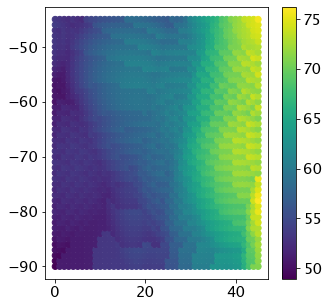

In [98]:
plt.rcParams['figure.figsize']=5,5
plt.scatter(df_contact_a['A1'],df_contact_a['A3'],c=df_contact_a['S'])
plt.colorbar()

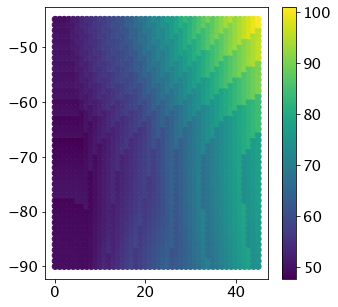

In [99]:
plt.rcParams['figure.figsize']=5,5
plt.scatter(df_contact_b['A1'],df_contact_b['A3'],c=df_contact_b['S'])
plt.colorbar()

glide=a

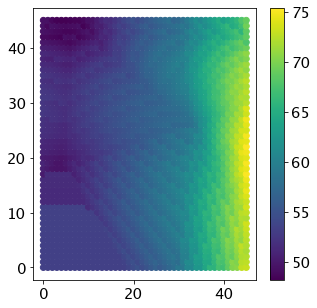

In [112]:
plt.rcParams['figure.figsize']=5,5
plt.scatter(df_contact_a['A1'],df_contact_a['A3'],c=df_contact_a['S'])
plt.colorbar()

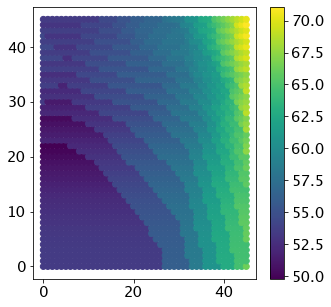

In [113]:
plt.rcParams['figure.figsize']=5,5
plt.scatter(df_contact_b['A1'],df_contact_b['A3'],c=df_contact_b['S'])
plt.colorbar()

glide=b

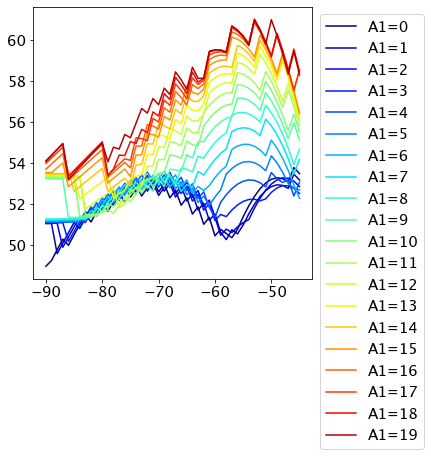

In [103]:
for A1 in np.arange(0,20):
    df_plot = df_contact_a[df_contact_a['A1']==A1].reset_index(drop=True)
    plt.plot(df_plot['A3'],df_plot['S'],c=cm.jet(A1/20),label='A1={}'.format(A1))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

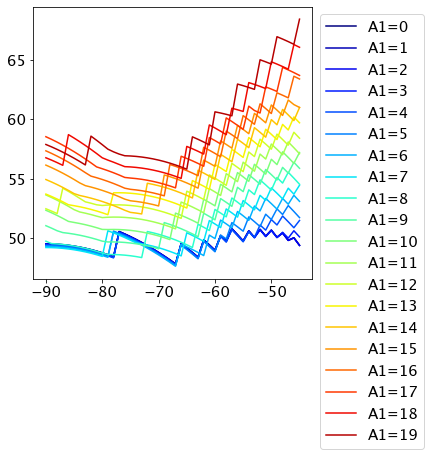

In [104]:
for A1 in np.arange(0,20):
    df_plot = df_contact_b[df_contact_b['A1']==A1].reset_index(drop=True)
    plt.plot(df_plot['A3'],df_plot['S'],c=cm.jet(A1/20),label='A1={}'.format(A1))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

glide=a

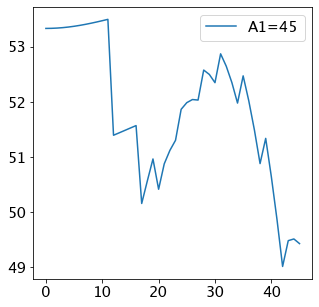

In [119]:
# for A1 in np.arange(0,46):
df_plot = df_contact_a[df_contact_a['A1']==0].reset_index(drop=True)
plt.plot(df_plot['A3'],df_plot['S'],label='A1={}'.format(A1))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

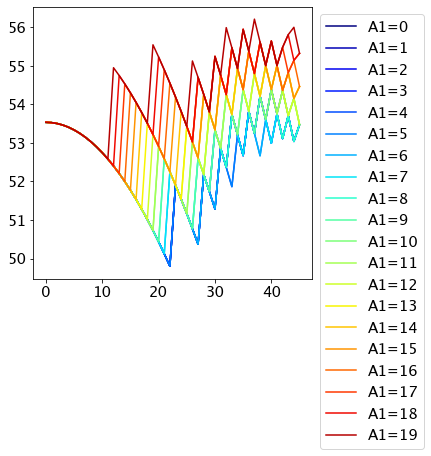

In [116]:
for A1 in np.arange(0,20):
    df_plot = df_contact_b[df_contact_b['A1']==A1].reset_index(drop=True)
    plt.plot(df_plot['A3'],df_plot['S'],c=cm.jet(A1/20),label='A1={}'.format(A1))
plt.legend(bbox_to_anchor=(1,1))
plt.show()